In [4]:
#import all libraries 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [5]:
#Function for Grey Scale image conversion
def greyscale(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#Function of Canny Edge Detection
def canny(img,low_threshold,high_threshold):
    return cv2.Canny(img,low_threshold, high_threshold)

#Function to filter the grey scale image
def gaussian_blur(img,kernel_size):
    return cv2.GaussianBlur(img,(kernel_size, kernel_size),0)

#Function to determine the region of interest from the Canny image
def reg_of_interest(img,vertices):
    mask=np.zeros_like(img)
    
    if len(img.shape)>2:
        channel_count=img.shape[2]
        ignore_mask_color = (255,)* channel_count
    else:
        ignore_mask_color=255
        
    cv2.fillPoly(mask,vertices, ignore_mask_color)
    
    masked_image=cv2.bitwise_and(img,mask)
    
    return masked_image

In [6]:
# Modified Draw Line Function which calculates the slope, averages and extrapolates the lines
def draw_line(img, lines, color=[255, 0, 0], thickness=10):
    imshape = img.shape
    left_one = []
    left_two = []
    right_one = []
    right_two = [] 
    y_one = img.shape[0]
    y_two = int(img.shape[0]*0.611)
    
    #Equation for line---> y=mx+b, m=(y-b)/x
    #Calculating the slope and finding the coefficients of line by polyfit function
    for line in lines:
        for x1,y1,x2,y2 in line:
            if ((y2-y1)/(x2-x1)) < 0:     #modified condition to check negative slope
                m = np.polyfit([x1, x2], [y1, y2], 1)
                left_one.append(np.int(np.float((y_one - m[1]))/np.float(m[0])))
                left_two.append(np.int(np.float((y_two - m[1]))/np.float(m[0])))
            elif ((y2-y1)/(x2-x1)) > 0:
                m = np.polyfit([x1, x2], [y1, y2], 1)
                right_one.append(np.int(np.float((y_one - m[1]))/np.float(m[0])))
                right_two.append(np.int(np.float((y_two - m[1]))/np.float(m[0])))
                
    #Calculating the average of calculated +/- slopes
    
    left_avg_x1 = np.int(np.nanmean(left_one))
    left_avg_x2 = np.int(np.nanmean(left_two))
    right_avg_x1 = np.int(np.nanmean(right_one))
    right_avg_x2 = np.int(np.nanmean(right_two))
    
    #Extrapolating the line with considerable thickness
    cv2.line(img, (left_avg_x1, y_one), (left_avg_x2, y_two), color, thickness)
    cv2.line(img, (right_avg_x1, y_one), (right_avg_x2, y_two), color, thickness) 

In [7]:
#Hough Transform function
def hough_lines(img,rho,theta,threshold,min_line_length, max_line_gap):
    lines=cv2.HoughLinesP(img,rho,theta,threshold, np.array([]),minLineLength=min_line_length,maxLineGap=max_line_gap)
    line_image=np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
    draw_line(line_image,lines)
    return line_image

#Weighted Image function
def weighted_image(img,initial_image,alpha=0.8,beta=1,gamma=0):
    return cv2.addWeighted(initial_image, alpha,img,beta,gamma)

In [8]:
#Whole Pipeline function 
def pipeline(image):  
    #Parameters for vertices of a 4 sided Polygon
    bot_left = [140, 540]
    bot_right = [980, 540]
    apex_right = [510, 315]
    apex_left = [450, 315]
    
    v = [np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)]
    
    # Run canny edge detection and mask region of interest
    gray = greyscale(image)
    blur = gaussian_blur(gray, 7)
    edge = canny(blur, 50, 125)
    mask = reg_of_interest(edge, v)
    
    ### Run Hough Lines and separate by +/- slope
    lines = cv2.HoughLinesP(mask, 0.8, np.pi/180, 25, np.array([]), minLineLength=50, maxLineGap=200)

    
    
    ### Draw lines and return final image 
    line_img = np.copy((image)*0)
    draw_line(line_img, lines, thickness=10)
    
    line_img = reg_of_interest(line_img, v)
    final = weighted_image(line_img, image)
    


    return final

In [9]:
from moviepy.editor import VideoFileClip, ImageClip
from IPython.display import HTML

def process_image(image):
    result = pipeline(image)
    return result

white_output = 'test_videos_output/whiteSolidRight.mp4'
clip1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/whiteSolidRight.mp4
[MoviePy] Writing video test_videos_output/whiteSolidRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:06<00:00, 33.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/whiteSolidRight.mp4 

Wall time: 7.42 s


In [10]:
from moviepy.editor import VideoFileClip, ImageClip
from IPython.display import HTML

def process_image(image):
    result = pipeline(image)
    return result

white_output = 'test_videos_output/YellowSolidLeft.mp4'
clip1 = VideoFileClip('test_videos/solidYellowLeft.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/YellowSolidLeft.mp4
[MoviePy] Writing video test_videos_output/YellowSolidLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:20<00:00, 33.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/YellowSolidLeft.mp4 

Wall time: 21.2 s


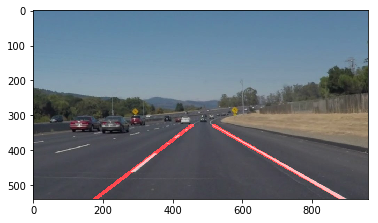

In [11]:
image=mpimg.imread("test_images/solidWhiteCurve.jpg")
result=pipeline(image)
plt.imshow(result)
plt.show()

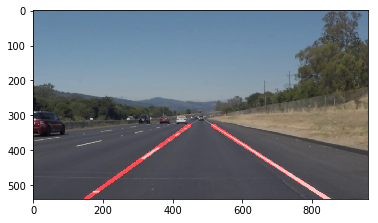

In [12]:
image=mpimg.imread("test_images/solidWhiteRight.jpg")
result=pipeline(image)
plt.imshow(result)
plt.show()

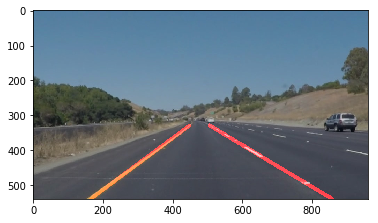

In [13]:
image=mpimg.imread("test_images/solidYellowCurve.jpg")
result=pipeline(image)
plt.imshow(result)
plt.show()

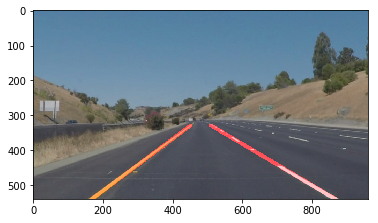

In [14]:
image=mpimg.imread("test_images/solidYellowCurve2.jpg")
result=pipeline(image)
plt.imshow(result)
plt.show()

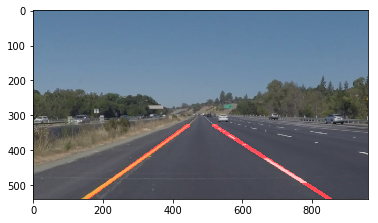

In [15]:
image=mpimg.imread("test_images/solidYellowLeft.jpg")
result=pipeline(image)
plt.imshow(result)
plt.show()

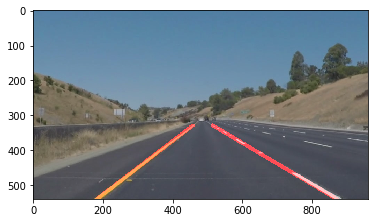

In [16]:
image=mpimg.imread("test_images/whiteCarLaneSwitch.jpg")
result=pipeline(image)
plt.imshow(result)
plt.show()